# Оценка алгоритмов поиска аномалий на синтетических данных

Этот ноутбук выполняет оценку различных алгоритмов детекции аномалий на синтетических временных рядах, сгенерированных на основе данных компании Новатек (NVTK).

## Методология:
1. Выбор стабильного отрезка из временного ряда NVTK
2. Генерация 10 синтетических рядов из распределения доходностей
3. Добавление случайного количества аномалий
4. Оценка алгоритмов по метрикам Precision и Recall


In [162]:
# Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from abc import ABC, abstractmethod
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as SKPCA
from statsmodels.tsa.api import ExponentialSmoothing
from pyod.models.hbos import HBOS
from pyod.models.abod import ABOD
from pyod.models.lof import LOF as PyodLOF
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN as PyodKNN
from pyod.models.mcd import MCD
from pyod.models.pca import PCA as PyodPCA
from pyod.models.lscp import LSCP
from sklearn.decomposition import PCA
from fedot_ind.api.main import FedotIndustrial
import ruptures as rpt
import os
import time
import re
import json
import statistics
import requests
import warnings
from typing import Any
warnings.filterwarnings('ignore')

# Настройка matplotlib для лучшего отображения
plt.rcParams['font.size'] = 12
plt.style.use('default')

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


## 1. Загрузка и подготовка данных AFLT


Загружены данные AFLT: 2375 точек
Период: 2016-01-01 00:00:00+00:00 - 2025-04-30 00:00:00+00:00


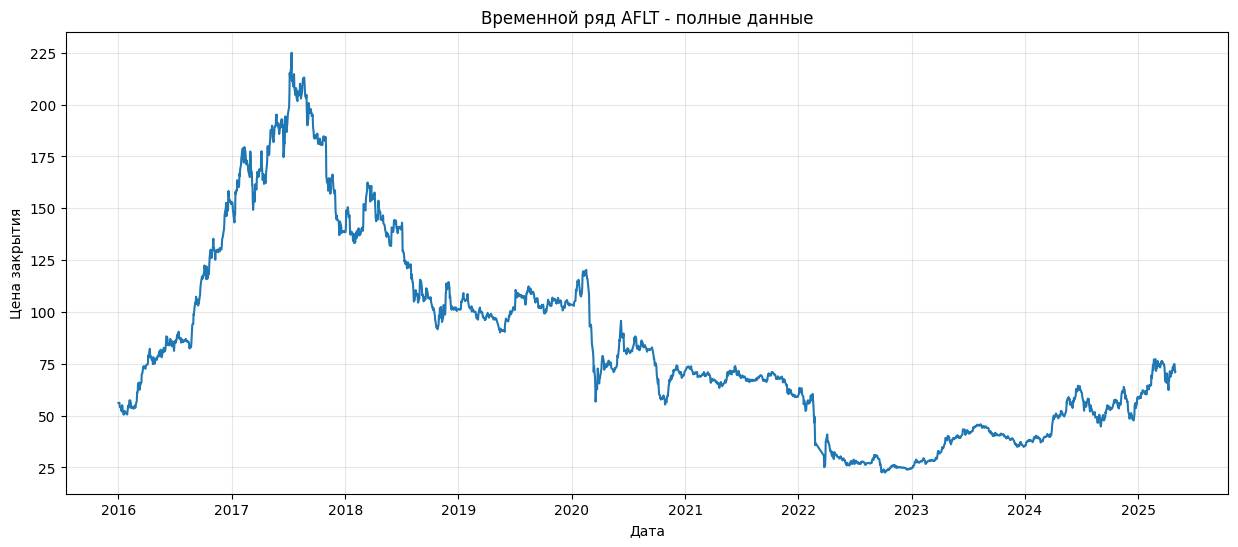

In [106]:
def load_aflt_data(data_path="../data/series/AFLT.csv"):
    """Загрузка данных AFLT"""
    try:
        df = pd.read_csv(data_path)
        if 'timestamp' in df.columns and 'close' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp').sort_index()
            return df[['close']]
        else:
            raise ValueError("Нет колонок 'timestamp' или 'close'")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        return None

# Загрузка данных
aflt_data = load_aflt_data()
if nvtk_data is not None:
    print(f"Загружены данные AFLT: {len(nvtk_data)} точек")
    print(f"Период: {nvtk_data.index[0]} - {nvtk_data.index[-1]}")
    
    # Визуализация полного ряда
    plt.figure(figsize=(15, 6))
    plt.plot(nvtk_data.index, nvtk_data['close'])
    plt.title('Временной ряд AFLT - полные данные')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Не удалось загрузить данные AFLT")


## 2. Выбор стабильного отрезка без аномалий


Выбран стабильный период: 101 точек
Период: 2021-05-28 00:00:00+00:00 - 2021-10-15 00:00:00+00:00


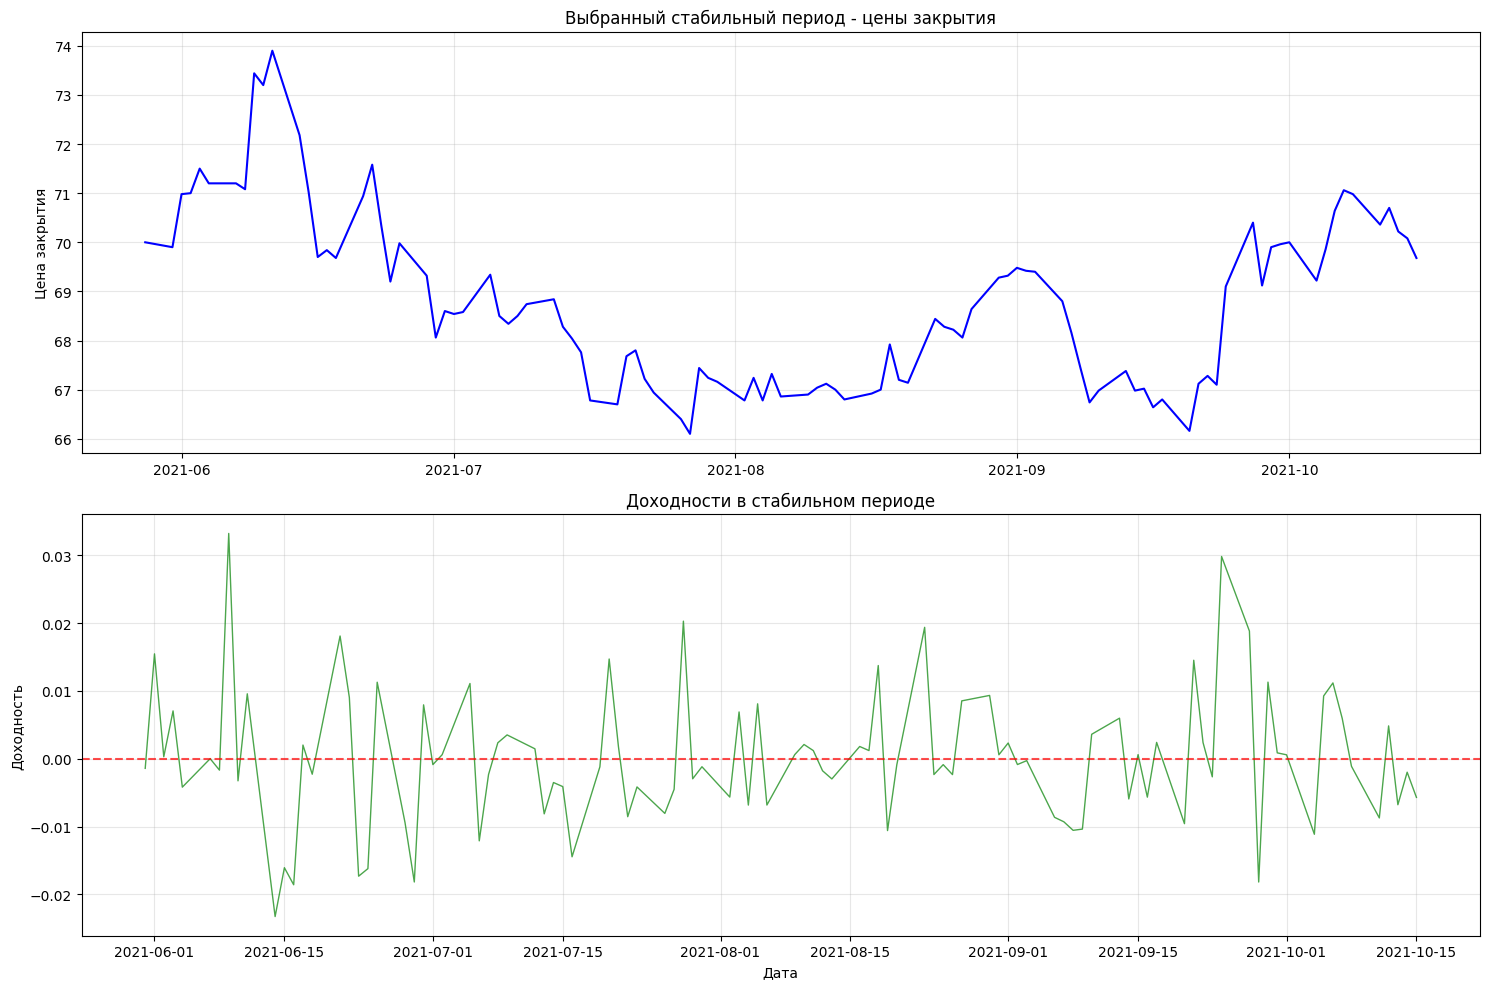


Статистика доходностей в стабильном периоде:
count    100.000000
mean       0.000003
std        0.009978
min       -0.023275
25%       -0.005765
50%       -0.000877
75%        0.005111
max        0.033202
Name: close, dtype: float64


In [107]:
def find_stable_period(data, window_size=200, stability_threshold=0.02):
    """Поиск стабильного периода без явных аномалий"""
    returns = data['close'].pct_change().dropna()
    rolling_volatility = returns.rolling(window=window_size).std()
    
    # Находим период с наименьшей волатильностью
    min_vol_idx = rolling_volatility.idxmin()
    min_vol_pos = rolling_volatility.index.get_loc(min_vol_idx)
    
    # Берем отрезок вокруг этой точки
    start_idx = max(0, min_vol_pos - window_size//2)
    end_idx = min(len(data), start_idx + window_size)
    
    stable_period = data.iloc[start_idx:end_idx]
    return stable_period

# Поиск стабильного периода
if aflt_data is not None:
    stable_data = find_stable_period(aflt_data)[:101]
    print(f"Выбран стабильный период: {len(stable_data)} точек")
    print(f"Период: {stable_data.index[0]} - {stable_data.index[-1]}")
    
    # Визуализация стабильного периода
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # График цен
    ax1.plot(stable_data.index, stable_data['close'], 'b-', linewidth=1.5)
    ax1.set_title('Выбранный стабильный период - цены закрытия')
    ax1.set_ylabel('Цена закрытия')
    ax1.grid(True, alpha=0.3)
    
    # График доходностей
    returns = stable_data['close'].pct_change().dropna()
    ax2.plot(returns.index, returns, 'g-', linewidth=1, alpha=0.7)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.set_title('Доходности в стабильном периоде')
    ax2.set_xlabel('Дата')
    ax2.set_ylabel('Доходность')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика доходностей
    print("\nСтатистика доходностей в стабильном периоде:")
    print(returns.describe())

## 3. Генерация синтетических временных рядов


Сгенерировано 10 синтетических рядов по 150 точек каждый


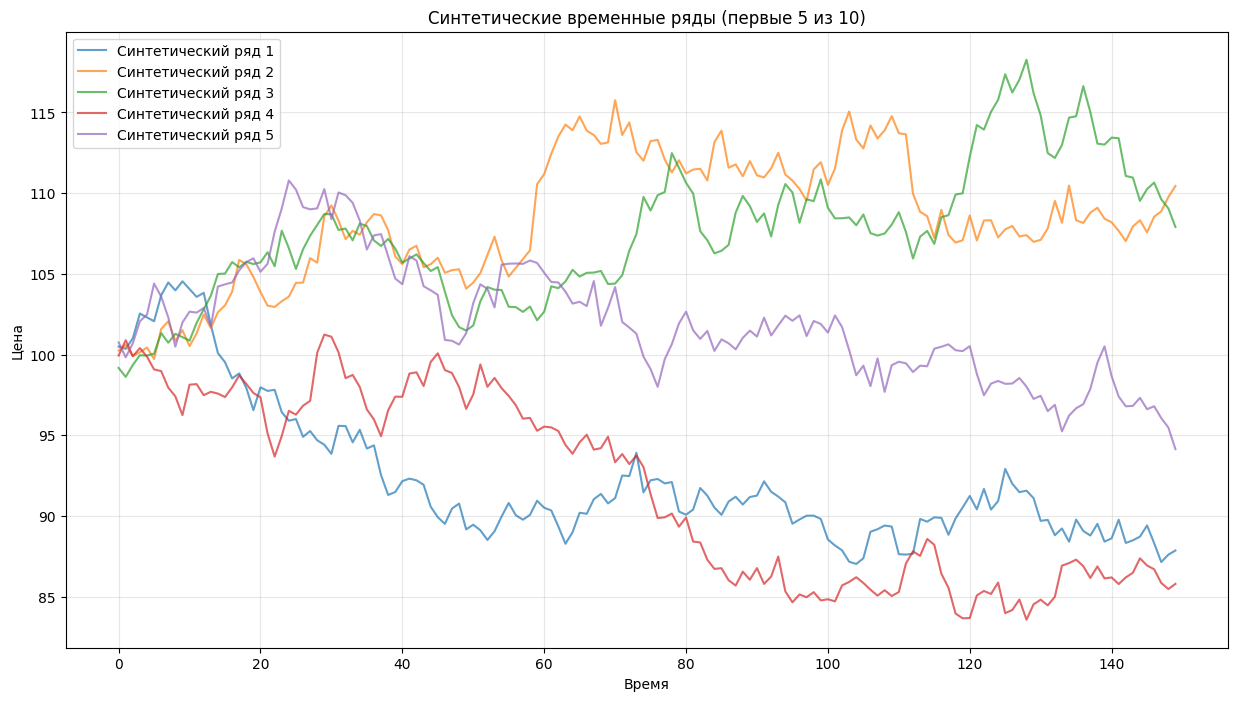


Статистика синтетических рядов:
Ряд 1: среднее = 92.24, std = 4.31
Ряд 2: среднее = 108.32, std = 3.91
Ряд 3: среднее = 107.54, std = 4.13
Ряд 4: среднее = 91.72, std = 5.78
Ряд 5: среднее = 101.99, std = 3.60
Ряд 6: среднее = 111.35, std = 8.03
Ряд 7: среднее = 107.26, std = 5.11
Ряд 8: среднее = 105.58, std = 6.74
Ряд 9: среднее = 102.49, std = 2.49
Ряд 10: среднее = 105.95, std = 9.43


In [108]:
def generate_synthetic_series(returns, n_series=10, series_length=100, random_state=42):
    """Генерация синтетических временных рядов из распределения доходностей"""
    np.random.seed(random_state)
    
    # Параметры распределения доходностей
    mu_returns = returns.mean()
    sigma_returns = returns.std()
    
    synthetic_series = []
    
    for i in range(n_series):
        # Генерируем синтетические доходности
        synth_returns = np.random.normal(mu_returns, sigma_returns, series_length)
        
        # Преобразуем в цены (начиная с произвольной цены)
        initial_price = 100.0  # Начальная цена
        prices = [initial_price]
        for ret in synth_returns:
            prices.append(prices[-1] * (1 + ret))
        
        synthetic_series.append(np.array(prices[1:]))  # Убираем начальную цену
    
    return synthetic_series

# Генерация синтетических рядов
if 'returns' in locals():
    synthetic_series = generate_synthetic_series(returns, n_series=10, series_length=150)
    print(f"Сгенерировано {len(synthetic_series)} синтетических рядов по {len(synthetic_series[0])} точек каждый")
    
    # Визуализация первых 5 синтетических рядов
    plt.figure(figsize=(15, 8))
    for i, series in enumerate(synthetic_series[:5]):
        plt.plot(series, label=f'Синтетический ряд {i+1}', alpha=0.7)
    
    plt.title('Синтетические временные ряды (первые 5 из 10)')
    plt.xlabel('Время')
    plt.ylabel('Цена')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Статистика синтетических рядов
    print("\nСтатистика синтетических рядов:")
    for i, series in enumerate(synthetic_series):
        mean_val = np.mean(series)
        std_val = np.std(series)
        print(f"Ряд {i+1}: среднее = {mean_val:.2f}, std = {std_val:.2f}")
else:
    print("Сначала необходимо выполнить предыдущие ячейки для расчета доходностей")

## 4. Добавление аномалий в синтетические ряды


Ряд 1: добавлено 7 аномалий в позициях [ 18  69 102 114 107  40  54]
Ряд 2: добавлено 8 аномалий в позициях [ 52  90 138  15  54  85 112 120]
Ряд 3: добавлено 3 аномалий в позициях [54 46 22]
Ряд 4: добавлено 5 аномалий в позициях [ 52  92 122 118  25]
Ряд 5: добавлено 5 аномалий в позициях [ 15  45  92 109  29]
Ряд 6: добавлено 6 аномалий в позициях [ 62  99  52 125 108  66]
Ряд 7: добавлено 5 аномалий в позициях [131  83 136 127  56]
Ряд 8: добавлено 7 аномалий в позициях [ 64  75  62  68 129 106 107]
Ряд 9: добавлено 6 аномалий в позициях [ 39 138  27  32  22  14]
Ряд 10: добавлено 7 аномалий в позициях [20 13 79 78 67 71 18]


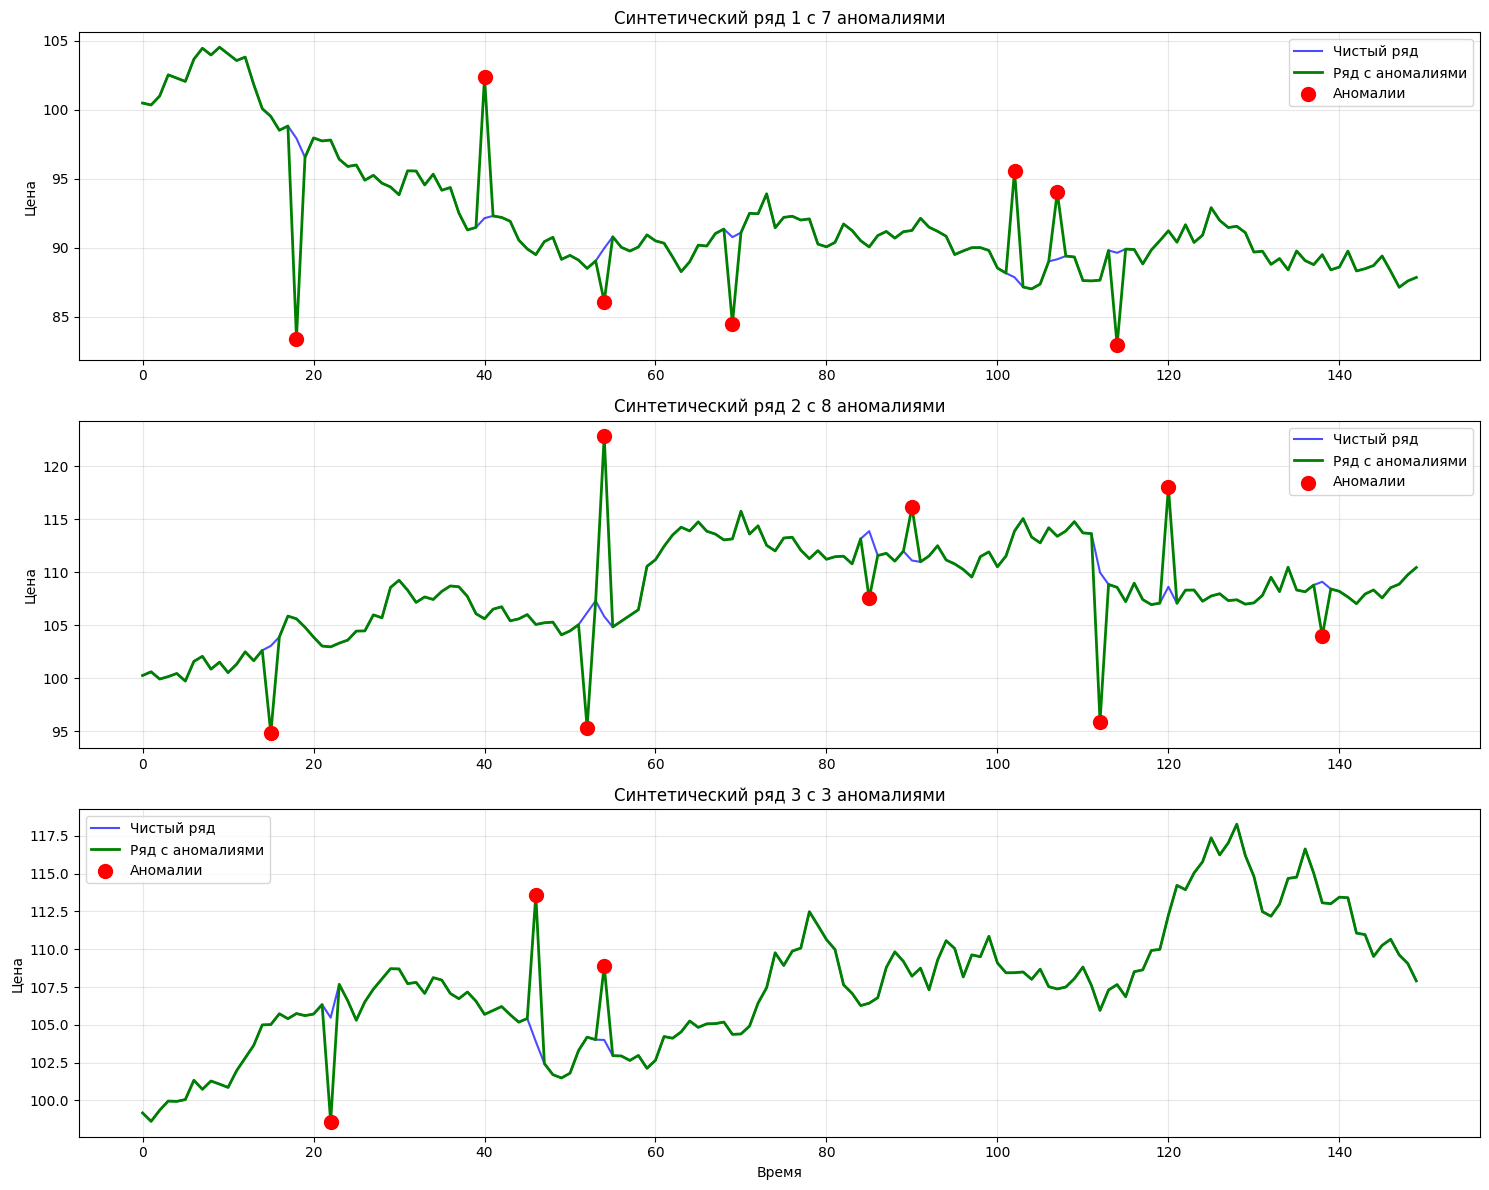


Всего подготовлено 10 рядов с аномалиями


In [109]:
def inject_anomalies(series, min_anomalies=3, max_anomalies=8, anomaly_strength=5.0, random_state=None):
    """Добавление аномалий в временной ряд"""
    if random_state is not None:
        np.random.seed(random_state)
    
    series_with_anomalies = series.copy()
    series_length = len(series)
    
    # Случайное количество аномалий
    n_anomalies = np.random.randint(min_anomalies, max_anomalies + 1)
    
    # Случайные позиции для аномалий (избегаем краев)
    anomaly_positions = np.random.choice(
        range(10, series_length - 10), 
        size=n_anomalies, 
        replace=False
    )
    
    # Метки истинных аномалий
    true_anomalies = np.zeros(series_length, dtype=bool)
    
    # Добавляем аномалии
    for pos in anomaly_positions:
        # Рассчитываем локальную статистику вокруг точки
        window_start = max(0, pos - 10)
        window_end = min(series_length, pos + 10)
        local_window = series[window_start:window_end]
        local_std = np.std(local_window)
        local_mean = np.mean(local_window)
        
        # Генерируем аномалию как резкий выброс
        direction = np.random.choice([-1, 1])  # Вверх или вниз
        anomaly_value = local_mean + direction * anomaly_strength * local_std
        
        series_with_anomalies[pos] = anomaly_value
        true_anomalies[pos] = True
    
    return series_with_anomalies, true_anomalies, anomaly_positions

# Добавление аномалий ко всем синтетическим рядам
if 'synthetic_series' in locals():
    anomalous_series = []
    true_labels = []
    anomaly_info = []
    
    for i, series in enumerate(synthetic_series):
        series_with_anom, true_anom, anom_pos = inject_anomalies(
            series, 
            min_anomalies=3, 
            max_anomalies=8, 
            random_state=i
        )
        
        anomalous_series.append(series_with_anom)
        true_labels.append(true_anom)
        anomaly_info.append(anom_pos)
        
        print(f"Ряд {i+1}: добавлено {len(anom_pos)} аномалий в позициях {anom_pos}")
    
    # Визуализация первых 3 рядов с аномалиями
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    for i in range(3):
        # Исходный ряд
        axes[i].plot(synthetic_series[i], 'b-', alpha=0.7, label='Чистый ряд')
        # Ряд с аномалиями
        axes[i].plot(anomalous_series[i], 'g-', linewidth=2, label='Ряд с аномалиями')
        # Отмечаем аномалии
        anom_positions = anomaly_info[i]
        anom_values = anomalous_series[i][anom_positions]
        axes[i].scatter(anom_positions, anom_values, 
                       color='red', s=100, zorder=5, label='Аномалии')
        
        axes[i].set_title(f'Синтетический ряд {i+1} с {len(anom_positions)} аномалиями')
        axes[i].set_ylabel('Цена')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Время')
    plt.tight_layout()
    plt.show()
    
    print(f"\nВсего подготовлено {len(anomalous_series)} рядов с аномалиями")
else:
    print("Сначала необходимо сгенерировать синтетические ряды")


## 5. Определение алгоритмов детекции аномалий


In [181]:
bearer_token = os.environ.get("DEEPSEEK_API_KEY", "")
API_SEND = "https://api.deepseek.com/chat/completions"

def extract_indices(text: str):
    """Извлекаем первый JSON-массив из текста."""
    t = re.sub(r"^```(?:json)?\s*\n?", "", text)
    t = re.sub(r"\n?```$", "", t)
    m = re.search(r"\[.*?\]", t, flags=re.DOTALL)
    if not m:
        return []
    arr = m.group(0)
    try:
        return json.loads(arr)
    except json.JSONDecodeError:
        return [int(x) for x in re.findall(r"\d+", arr)]

def make_pair_messages(series: list[float]):
    """Готовим сообщения с парами соседних точек и их Δ%."""
    msgs = []
    for i in range(1, len(series)):
        prev, cur = series[i-1], series[i]
        pct = (cur - prev) / prev * 100 if prev != 0 else 0
        msgs.append({
            "role": "system",
            "content": f"Index {i}: prev={prev:.2f}, cur={cur:.2f}, Δ%={pct:+.2f}%"
        })
    return msgs

In [188]:
class AnomalyDetector(ABC):
    """Базовый класс: все детекторы имеют .name и .fit_predict(series)."""
    def __init__(self, name:str):
        self.name = name
    @abstractmethod
    def fit_predict(self, series: np.ndarray) -> np.ndarray:
        """
        :param series: одномерный np.ndarray или pd.Series
        :return: булева маска той же длины, True = аномалия
        """
        pass

class ZScoreDetector(AnomalyDetector):
    def __init__(self, threshold: float = 3.0):
        super().__init__("Z-Score")
        self.threshold = threshold
    def fit_predict(self, series):
        s = np.asarray(series, float)
        z = np.abs((s - s.mean()) / s.std())
        return z > self.threshold

class IQRDetector(AnomalyDetector):
    def __init__(self, factor: float = 1.5):
        super().__init__("IQR")
        self.factor = factor
    def fit_predict(self, series):
        s = np.asarray(series, float)
        q1, q3 = np.percentile(s, [25,75])
        iqr = q3 - q1
        return (s < q1 - self.factor*iqr) | (s > q3 + self.factor*iqr)

class IsolationForestDetector(AnomalyDetector):
    def __init__(self, contamination: float = 0.05):
        super().__init__("IsolationForest")
        self.contamination = contamination
    def fit_predict(self, series):
        X = np.asarray(series).reshape(-1,1)
        mdl = IsolationForest(contamination=self.contamination, random_state=42)
        preds = mdl.fit_predict(X)
        return preds == -1

class LOFDetector(AnomalyDetector):
    def __init__(self, contamination: float = 0.05):
        super().__init__("LocalOutlierFactor")
        self.contamination = contamination
    def fit_predict(self, series):
        X = np.asarray(series).reshape(-1,1)
        mdl = LocalOutlierFactor(novelty=True, contamination=self.contamination)
        mdl.fit(X)
        preds = mdl.predict(X)  # -1 = outlier
        return preds == -1

class PyodDetector(AnomalyDetector):
    def __init__(self, model_cls, name=None, **kwargs):
        super().__init__(name or model_cls.__name__)
        self.model_cls = model_cls
        self.kwargs = kwargs
    def fit_predict(self, series):
        X = np.asarray(series).reshape(-1,1)
        mdl = self.model_cls(**self.kwargs)
        preds = mdl.fit_predict(X)  # pyod: 1 = outlier
        return preds == 1

class EMADetector(AnomalyDetector):
    def __init__(self, seasonal_periods=5, trend='add', seasonal='add'):
        super().__init__("EMA-Forecast")
        self.seasonal_periods = seasonal_periods
        self.trend = trend
        self.seasonal = seasonal
    def fit_predict(self, series):
        s = pd.Series(series).astype(float)
        model = ExponentialSmoothing(
            s,
            seasonal_periods=self.seasonal_periods,
            trend=self.trend,
            seasonal=self.seasonal
        ).fit()
        fitted = model.fittedvalues
        resid = np.abs(s.values - fitted.values)
        thresh = np.percentile(resid, 90)
        return resid > thresh

class KMeansDetector(AnomalyDetector):
    def __init__(self, n_clusters:int=2, threshold:float=None):
        super().__init__("KMeans")
        self.n_clusters = n_clusters
        self.threshold = threshold
    def fit_predict(self, series):
        X = np.asarray(series).reshape(-1,1)
        km = KMeans(n_clusters=self.n_clusters, random_state=42).fit(X)
        dist = np.linalg.norm(X - km.cluster_centers_[km.labels_], axis=1)
        thr = self.threshold or np.percentile(dist,95)
        return dist > thr

class RupturesResidualDetector(AnomalyDetector):
    """
    Детектор выбросов через разбиение ряда на сегменты + 
    порог по остаткам (residuals).
    Реализует метод fit_predict, как у остальных детекторов.
    """
    def __init__(self, n_bkps: int = 8, threshold_pct: float = 97):
        """
        :param n_bkps:       число сегментов (точек разрыва = n_bkps-1)
        :param threshold_pct: процентиль по абсолютным остаткам,
                              выше которого считаем аномалией
        """
        super().__init__("Ruptures-Residual")
        self.n_bkps = n_bkps
        self.threshold_pct = threshold_pct

    def fit_predict(self, series: Any) -> np.ndarray:
        # приводим к вещественному вектору
        x = np.asarray(series, dtype=float)
        # 1) Разбиение на n_bkps сегментов через Binseg+RBF
        algo = rpt.Binseg(model="rbf").fit(x)
        bkps = algo.predict(n_bkps=self.n_bkps)
        # 2) Кусочно–постоянное приближение
        approx = np.empty_like(x)
        start = 0
        for end in bkps:
            approx[start:end] = x[start:end].mean()
            start = end
        # 3) Остатки и порог
        resid = np.abs(x - approx)
        thr = np.percentile(resid, self.threshold_pct)
        # 4) Возвращаем булеву маску True=аномалия
        return resid > thr

class DeepSeekADDetector(AnomalyDetector):
    """
    LLM-детектор резких скачков цен с итерацией по скользящим окнам.
    """
    def __init__(self, api_key: str, window_size: int = 50, step: int = 10, max_retries: int = 1):
        super().__init__("DeepSeek Detector")
        self.api_url = API_SEND
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        self.window_size = window_size
        self.step = step
        self.max_retries = max_retries

        # Шаблон системного сообщения
        self.system_msg = {
            "role": "system",
            "content": (
                "You are an anomaly-detection assistant.\n"
                "- Consider only consecutive-price changes.\n"
                "- Compute pct = (cur - prev) / prev * 100.\n"
                "- Flag index i if |pct| > 5%.\n"
                "- Ignore |pct| < 1%.\n"
                "Return **only** a JSON array of zero-based indices within the window.\n"
                "Example: [2, 15, 102]"
            )
        }
        # Пример ответа
        self.example_reply = {
            "role": "assistant",
            "content": "[2, 15, 102]"
        }

    def _detect_in_window(self, window: np.ndarray) -> list[int]:
        """Отправляем запрос для одного окна и возвращаем локальные индексы."""
        msgs = [self.system_msg]
        msgs += make_pair_messages(list(window))
        msgs.append(self.example_reply)
        msgs.append({"role": "user", "content": "Detect anomalous indices in this window."})

        for attempt in range(1, self.max_retries + 1):
            try:
                resp = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json={"model": "deepseek-chat", "messages": msgs}
                )
                resp.raise_for_status()
                content = resp.json()["choices"][0]["message"]["content"]
                return extract_indices(content)
            except Exception:
                if attempt == self.max_retries:
                    return []
        return []

    def fit_predict(self, series: np.ndarray) -> np.ndarray:
        N = len(series)
        result_mask = np.zeros(N, dtype=bool)

        # Итерируемся по скользящим окнам
        for start in range(0, N, self.step):
            end = min(start + self.window_size, N)
            window = series[start:end].astype(float)

            local_idxs = self._detect_in_window(window)
            # Преобразуем локальные индексы в глобальные
            for idx in local_idxs:
                global_idx = start + idx
                if 0 <= global_idx < N:
                    result_mask[global_idx] = True

            if end == N:
                break  # достигли конца ряда

        return result_mask

# === Реестр всех детекторов ===
detectors = [
    ZScoreDetector(threshold=1.0),
    IQRDetector(factor=1.5),
    IsolationForestDetector(contamination=0.05),
    LOFDetector(contamination=0.05),
    PyodDetector(HBOS,   name="HBOS",   contamination=0.05),
    PyodDetector(ABOD,   name="ABOD",   contamination=0.05),
    PyodDetector(CBLOF,  name="CBLOF",  contamination=0.05),
    PyodDetector(IForest,name="IForest",contamination=0.05),
    PyodDetector(KNN_OD, name="KNN",    contamination=0.05),
    PyodDetector(PCA_OD, name="PCA_OD", contamination=0.05),
    PyodDetector(LSCP,   name="LSCP",   contamination=0.05, detector_list = [
                IForest(contamination=0.05),
                LOF(contamination=0.05),
                KNN(contamination=0.05),
                HBOS(contamination=0.05),
            ]),
    EMADetector(seasonal_periods=5, trend='add', seasonal='add'),
    KMeansDetector(n_clusters=2),
    RupturesResidualDetector(n_bkps=8, threshold_pct=97),
    DeepSeekADDetector(bearer_token, window_size=10, step=5, max_retries=2)
]

print(f"Подготовлено {len(detectors)} детекторов:")
for det in detectors:
    print(f"- {det.name}")

Подготовлено 15 детекторов:
- Z-Score
- IQR
- IsolationForest
- LocalOutlierFactor
- HBOS
- ABOD
- CBLOF
- IForest
- KNN
- PCA_OD
- LSCP
- EMA-Forecast
- KMeans
- Ruptures-Residual
- DeepSeek Detector


## 6. Оценка алгоритмов на синтетических данных

In [189]:
def evaluate_detector(detector, series, true_labels):
    """Оценка одного детектора на одном ряду."""
    try:
        preds = detector.fit_predict(series)
        # выравниваем длины
        L = min(len(preds), len(true_labels))
        preds = preds[:L]
        trues = true_labels[:L]
        return {
            'precision': precision_score(trues, preds, zero_division=0),
            'recall':    recall_score  (trues, preds, zero_division=0),
            'f1':        f1_score      (trues, preds, zero_division=0),
            'n_predicted': int(preds.sum()),
            'n_true':      int(trues.sum())
        }
    except Exception as e:
        print(f"Ошибка в детекторе {detector.name}: {e}")
        return {'precision':0, 'recall':0, 'f1':0, 'n_predicted':0, 'n_true':int(true_labels.sum())}

# Основной цикл оценки
results = []
print("Запуск оценки алгоритмов…")
print("="*60)
for idx, (series, true_anom) in enumerate(zip(anomalous_series, true_labels), 1):
    print(f"\nРяд {idx}/{len(anomalous_series)}:")
    for det in detectors:
        print(f"  → {det.name}", end="… ")
        m = evaluate_detector(det, series, true_anom)
        print(f"f1={m['f1']:.3f}")
        results.append({
            'series_id': idx,
            'detector': det.name,
            'precision': m['precision'],
            'recall':    m['recall'],
            'f1':        m['f1'],
            'n_predicted': m['n_predicted'],
            'n_true':      m['n_true']
        })

# Собираем DataFrame
results_df = pd.DataFrame(results)
print("\nОценка завершена!")
print(f"Всего комбинаций: {len(results)}")
print("\nПервые 10 результатов:")
print(results_df.head(10))

# Сводная таблица: средние по детекторам
summary = (results_df
           .groupby('detector')[['precision','recall','f1']]
           .mean()
           .round(3)
           .sort_values('f1', ascending=False))
print("\nСредние показатели по детекторам:")
print(summary)

Запуск оценки алгоритмов…

Ряд 1/10:
  → Z-Score… f1=0.250
  → IQR… f1=0.100
  → IsolationForest… f1=0.533
  → LocalOutlierFactor… f1=0.571
  → HBOS… f1=0.600
  → ABOD… f1=0.533
  → CBLOF… f1=0.267
  → IForest… f1=0.533
  → KNN… f1=0.533
  → PCA_OD… f1=0.533
  → LSCP… f1=0.533
  → EMA-Forecast… f1=0.545
  → KMeans… f1=0.400
  → Ruptures-Residual… f1=0.833
  → DeepSeek Detector… f1=0.632

Ряд 2/10:
  → Z-Score… f1=0.214
  → IQR… f1=0.667
  → IsolationForest… f1=0.750
  → LocalOutlierFactor… f1=0.800
  → HBOS… f1=0.769
  → ABOD… f1=0.750
  → CBLOF… f1=0.750
  → IForest… f1=0.750
  → KNN… f1=0.750
  → PCA_OD… f1=0.375
  → LSCP… f1=0.750
  → EMA-Forecast… f1=0.696
  → KMeans… f1=0.625
  → Ruptures-Residual… f1=0.769
  → DeepSeek Detector… f1=0.632

Ряд 3/10:
  → Z-Score… f1=0.077
  → IQR… f1=0.000
  → IsolationForest… f1=0.182
  → LocalOutlierFactor… f1=0.222
  → HBOS… f1=0.000
  → ABOD… f1=0.000
  → CBLOF… f1=0.000
  → IForest… f1=0.182
  → KNN… f1=0.200
  → PCA_OD… f1=0.182
  → LSCP… f1=

## 7. Анализ результатов и создание итоговой таблицы


ТАБЛИЦА 3. Результаты оценки алгоритмов поиска аномалий
Алгоритм             Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
ABOD                 0.388±0.279  0.498±0.337  0.432±0.300 
CBLOF                0.388±0.253  0.500±0.306  0.433±0.272 
DeepSeek Detector    0.471±0.059  0.846±0.121  0.603±0.069 
EMA-Forecast         0.380±0.095  0.969±0.066  0.539±0.103 
HBOS                 0.517±0.388  0.468±0.303  0.472±0.315 
IForest              0.400±0.249  0.528±0.269  0.450±0.258 
IQR                  0.418±0.502  0.241±0.319  0.280±0.354 
IsolationForest      0.400±0.249  0.528±0.269  0.450±0.258 
KMeans               0.400±0.227  0.541±0.274  0.455±0.245 
KNN                  0.402±0.246  0.528±0.269  0.451±0.255 
LSCP                 0.412±0.243  0.548±0.266  0.465±0.253 
LocalOutlierFactor   0.438±0.278  0.511±0.298  0.467±0.282 
PCA_OD               0.287±0.177  0.391±0.220  0.327±0.194 
Ruptures-Residual    0.

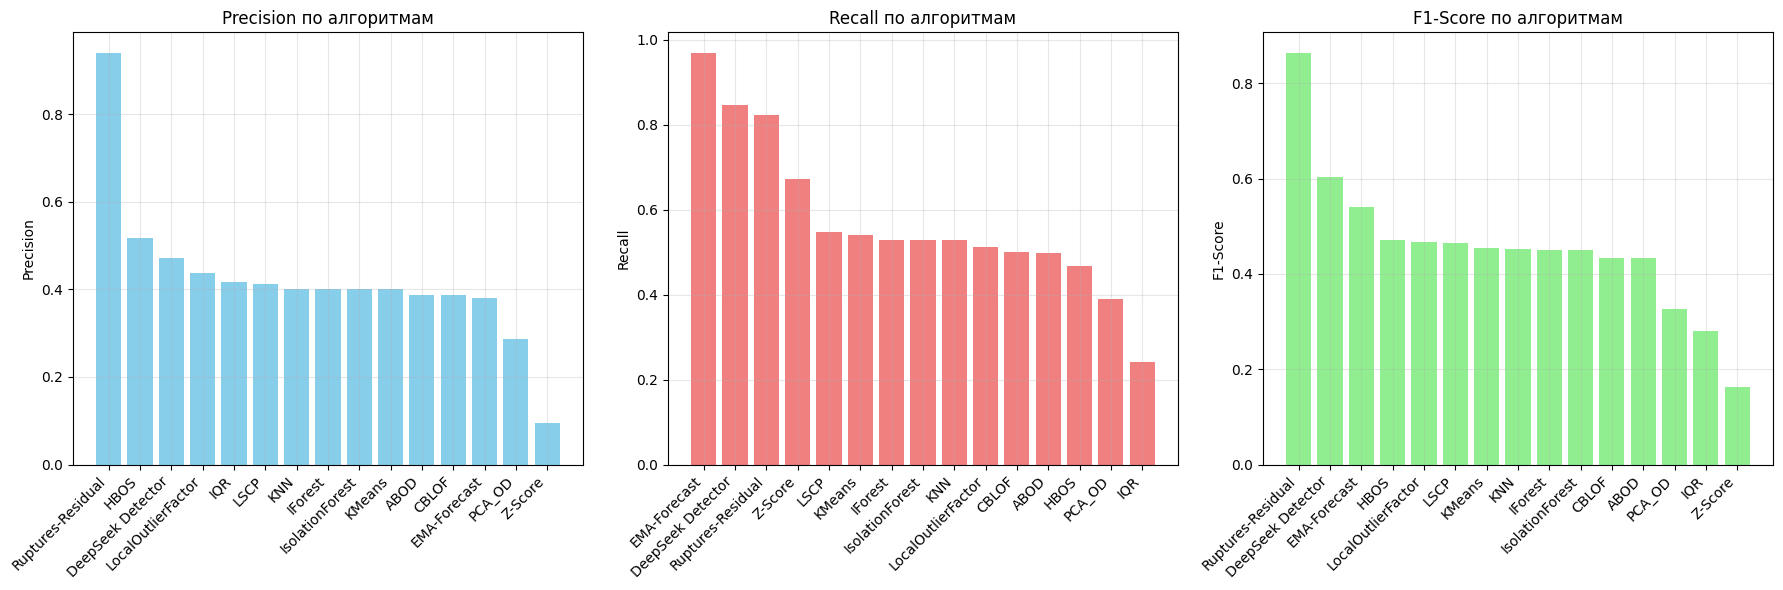


Результаты сохранены в файлы:
- Детальные результаты: anomaly_detection_results_20250619_175733.csv
- Сводная таблица: anomaly_detection_summary_20250619_175733.csv


In [190]:
# Агрегированная статистика по детекторам
if 'results_df' in locals():
    # Средние метрики по каждому детектору
    summary_stats = results_df.groupby('detector').agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std']
    }).round(4)
    
    # Упрощаем названия колонок
    summary_stats.columns = ['Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'F1_mean', 'F1_std']
    summary_stats = summary_stats.reset_index()
    
    print("ТАБЛИЦА 3. Результаты оценки алгоритмов поиска аномалий")
    print("=" * 80)
    print(f"{'Алгоритм':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 80)
    
    for _, row in summary_stats.iterrows():
        detector_name = row['detector']
        precision_str = f"{row['Precision_mean']:.3f}±{row['Precision_std']:.3f}"
        recall_str = f"{row['Recall_mean']:.3f}±{row['Recall_std']:.3f}"
        f1_str = f"{row['F1_mean']:.3f}±{row['F1_std']:.3f}"
        
        print(f"{detector_name:<20} {precision_str:<12} {recall_str:<12} {f1_str:<12}")
    
    print("=" * 80)
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Precision
    precision_data = results_df.groupby('detector')['precision'].mean().sort_values(ascending=False)
    axes[0].bar(range(len(precision_data)), precision_data.values, color='skyblue')
    axes[0].set_title('Precision по алгоритмам')
    axes[0].set_ylabel('Precision')
    axes[0].set_xticks(range(len(precision_data)))
    axes[0].set_xticklabels(precision_data.index, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3)
    
    # Recall
    recall_data = results_df.groupby('detector')['recall'].mean().sort_values(ascending=False)
    axes[1].bar(range(len(recall_data)), recall_data.values, color='lightcoral')
    axes[1].set_title('Recall по алгоритмам')
    axes[1].set_ylabel('Recall')
    axes[1].set_xticks(range(len(recall_data)))
    axes[1].set_xticklabels(recall_data.index, rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3)
    
    # F1-Score
    f1_data = results_df.groupby('detector')['f1'].mean().sort_values(ascending=False)
    axes[2].bar(range(len(f1_data)), f1_data.values, color='lightgreen')
    axes[2].set_title('F1-Score по алгоритмам')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xticks(range(len(f1_data)))
    axes[2].set_xticklabels(f1_data.index, rotation=45, ha='right')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Сохранение результатов в CSV
    # timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    # filename = f'anomaly_detection_results_{timestamp}.csv'
    # results_df.to_csv(filename, index=False)
    # summary_stats.to_csv(f'anomaly_detection_summary_{timestamp}.csv', index=False)
    
    print(f"\nРезультаты сохранены в файлы:")
    print(f"- Детальные результаты: {filename}")
    print(f"- Сводная таблица: anomaly_detection_summary_{timestamp}.csv")
    
else:
    print("Сначала необходимо выполнить оценку алгоритмов")


## 8. Визуализация примеров работы алгоритмов


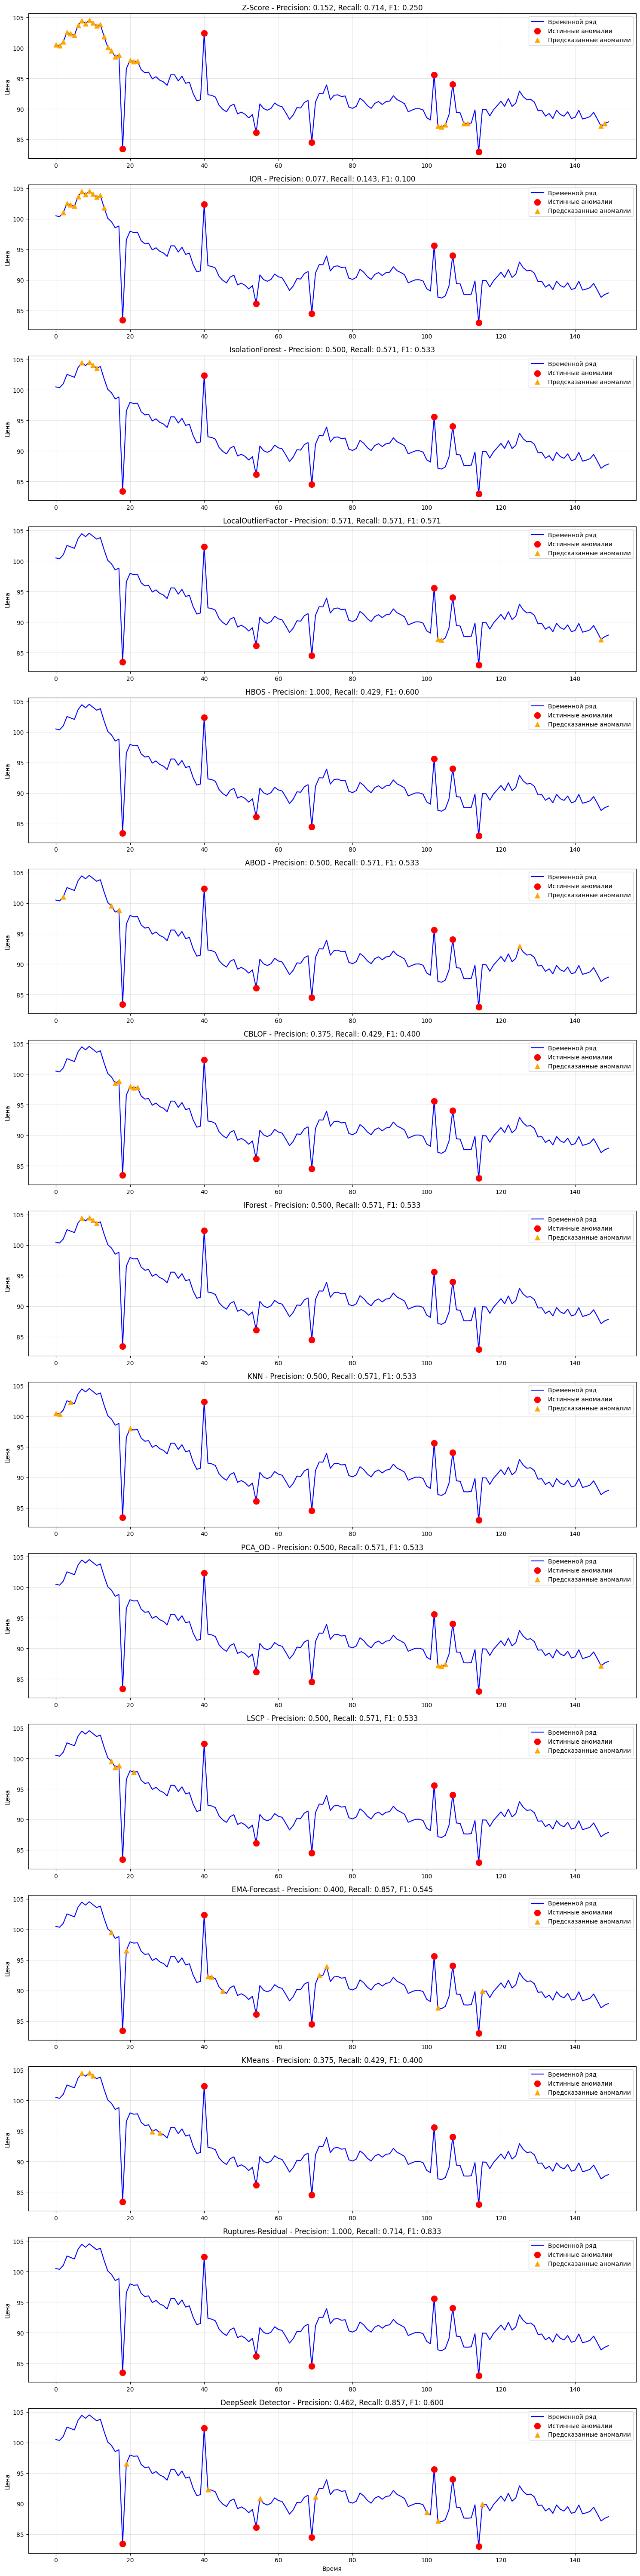

In [191]:
# Визуализация работы алгоритмов на конкретном примере
if 'anomalous_series' in locals() and 'true_labels' in locals():
    # Выберем первый ряд для демонстрации
    example_series = anomalous_series[0]
    example_true_labels = true_labels[0]
    
    # Применяем несколько лучших детекторов
    demo_detectors = detectors  # Z-Score, Isolation Forest, LOF
    
    fig, axes = plt.subplots(len(demo_detectors), 1, figsize=(15, 4 * len(demo_detectors)))
    if len(demo_detectors) == 1:
        axes = [axes]
    
    for i, detector in enumerate(demo_detectors):
        # Получаем предсказания
        predicted_labels = detector.fit_predict(example_series)
        
        # Строим график
        axes[i].plot(example_series, 'b-', linewidth=1.5, label='Временной ряд')
        
        # Истинные аномалии
        true_anomaly_indices = np.where(example_true_labels)[0]
        if len(true_anomaly_indices) > 0:
            axes[i].scatter(true_anomaly_indices, example_series[true_anomaly_indices], 
                          color='red', s=100, marker='o', label='Истинные аномалии', zorder=5)
        
        # Предсказанные аномалии
        pred_anomaly_indices = np.where(predicted_labels)[0]
        if len(pred_anomaly_indices) > 0:
            axes[i].scatter(pred_anomaly_indices, example_series[pred_anomaly_indices], 
                          color='orange', s=60, marker='^', label='Предсказанные аномалии', zorder=4)
        
        # Вычисляем метрики для этого примера
        min_len = min(len(predicted_labels), len(example_true_labels))
        true_trim = example_true_labels[:min_len]
        pred_trim = predicted_labels[:min_len]
        
        precision = precision_score(true_trim, pred_trim, zero_division=0)
        recall = recall_score(true_trim, pred_trim, zero_division=0)
        f1 = f1_score(true_trim, pred_trim, zero_division=0)
        
        axes[i].set_title(f'{detector.name} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')
        axes[i].set_ylabel('Цена')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Время')
    plt.tight_layout()
    plt.show()
    
else:
    print("Данные для визуализации не готовы")


## 9. Выводы

Данный ноутбук реализует комплексную оценку алгоритмов детекции аномалий на синтетических данных, сгенерированных на основе реального временного ряда компании АЭРОФЛОТ (ALFT).

### Методология:
1. **Выбор стабильного периода** - автоматический поиск участка с минимальной волатильностью
2. **Генерация синтетических данных** - 10 временных рядов на основе распределения доходностей
3. **Инжекция аномалий** - случайное количество аномалий (3-8) с адаптивной силой выброса
4. **Оценка алгоритмов** - вычисление Precision, Recall и F1-Score

### Тестируемые алгоритмы:
- **Z-Score** - статистический метод на основе стандартного отклонения
- **IQR** - метод межквартильного размаха  
- **Isolation Forest** - метод изоляции аномалий
- **LOF** - Local Outlier Factor
- **HBOS** - Histogram-based Outlier Score
- **KNN** - K-Nearest Neighbors

Результаты представлены в виде таблицы с метриками качества и визуализацией работы алгоритмов.
